In [4]:
#!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 4.5 MB/s eta 0:00:00


In [1]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
%cd gdrive/MyDrive

/content/gdrive/MyDrive


In [5]:
# Libraries

import pandas as pd
import time
import numpy as np
import random
import os
from tqdm import tqdm
import itertools
import PIL

# Data Analysis
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

#TensorFlow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import array_to_img
import keras_tuner as kt
from tensorflow import keras

# Sklearn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Classes Tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

%matplotlib inline

In [6]:
# Emplacement
path = '/content/gdrive/MyDrive/Projet Radio DST/data'

dirs = ["Normal/images/","COVID/images/","Lung_Opacity/images/","Viral Pneumonia/images/"]
dirsm = ["Normal/masks/","COVID/masks/","Lung_Opacity/masks/","Viral Pneumonia/masks/"]

id_dir = 6

# Classes de 0 à 3 dans la suite
classes = ("Normal","COVID ","Lung_Opacity","Viral Pneumonia") 
nbClasses = len(classes)

In [7]:
# Création des 4 listes de noms d'images

normal_imgs = [fn for fn in os.listdir(f'{path}/Normal/masked_images') if fn.endswith('.png')]
covid_imgs = [fn for fn in os.listdir(f'{path}/COVID/masked_images') if fn.endswith('.png')]
pneumonia_imgs = [fn for fn in os.listdir(f'{path}/Viral Pneumonia/masked_images') if fn.endswith('.png')]
lung_opacity_imgs = [fn for fn in os.listdir(f'{path}/Lung_Opacity/masked_images') if fn.endswith('.png')]

In [8]:
# Concaténation des emplacements de toutes les images dans une liste unique
liste_paths = []

for fn in normal_imgs :
    liste_paths.append(f'{path}/Normal/masked_images/' + fn)
for fn in covid_imgs :
    liste_paths.append(f'{path}/COVID/masked_images/' + fn)
for fn in pneumonia_imgs :
    liste_paths.append(f'{path}/Viral Pneumonia/masked_images/' + fn)
for fn in lung_opacity_imgs :
    liste_paths.append(f'{path}/Lung_Opacity/masked_images/' + fn)

# Découpage des noms de chaque emplacement et récupération de la classe (liste de listes)
liste_paths_classes = list(map(lambda x : [x, x.split('/')[id_dir]], liste_paths)) 

In [9]:
# Création Dataframe des emplacements et classes images BRUTES
df = pd.DataFrame(liste_paths_classes, columns = ['filepath', 'nameLabel'])

# Remplacement des classes sous forme littérale par index
df['label'] = df['nameLabel'].replace(df.nameLabel.unique(), [*range(len(df.nameLabel.unique()))])
df['label'] = df['label'].astype(str)

# Mélange du dataframe
df = df.sample(frac = 1, random_state = 42)
df = df.reset_index(drop=True)

# Nettoyage variables inutiles
del liste_paths

ech_size = 2000

df = df[0:ech_size]
print(df['nameLabel'].value_counts())
df.head()

Lung_Opacity       500
Normal             500
Viral Pneumonia    500
COVID              500
Name: nameLabel, dtype: int64


,filepath,nameLabel,label
0,/content/gdrive/MyDrive/Projet Radio DST/data/...,Lung_Opacity,3
1,/content/gdrive/MyDrive/Projet Radio DST/data/...,Normal,0
2,/content/gdrive/MyDrive/Projet Radio DST/data/...,Viral Pneumonia,2
3,/content/gdrive/MyDrive/Projet Radio DST/data/...,COVID,1
4,/content/gdrive/MyDrive/Projet Radio DST/data/...,Viral Pneumonia,2


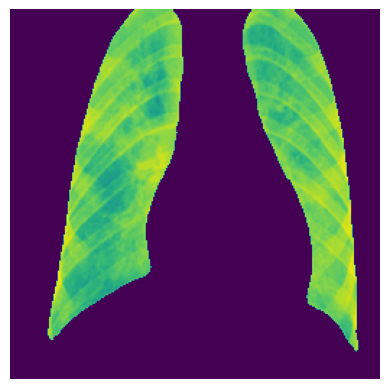

In [10]:
#Charger Exemple Image
filepath = df.filepath[9]

im = tf.io.read_file(filepath)
im = tf.image.decode_jpeg(im, channels = 1)
plt.imshow(im)
plt.axis('off');

In [11]:
size = (256, 256)
ratio_val = 0.2 
batch_generator = 32

# Séparation dataframe en ensemble entraiement et validation
train_total, test = train_test_split(df, test_size = ratio_val, shuffle = False)
train, valid = train_test_split(train_total, test_size = 0.1)

# Création des itérateurs qui chargeront des lots d'images
datagen = ImageDataGenerator( )
test_datagen = ImageDataGenerator( )

print(f"Number of rows in TRAIN total set: {len(train_total)}")
print(f" - Number of rows in train_set: {len(train)}")
print(f" - Number of rows in valid_set: {len(valid)}")

train_generator = datagen.flow_from_dataframe(dataframe = train,
                                              x_col="filepath",
                                              y_col="label",
                                              class_mode = "sparse",
                                              target_size = size,
                                              batch_size = batch_generator,
                                              color_mode = "grayscale")

valid_generator = datagen.flow_from_dataframe(dataframe = valid,
                                              x_col="filepath",
                                              y_col="label",
                                              class_mode = "sparse",
                                              target_size = size,
                                              batch_size = batch_generator,
                                              color_mode = "grayscale")


Number of rows in TRAIN total set: 1600
 - Number of rows in train_set: 1440
 - Number of rows in valid_set: 160
Found 1440 validated image filenames belonging to 4 classes.
Found 160 validated image filenames belonging to 4 classes.


In [12]:
print(f"Number of rows in TEST set: {len(test)}")

test_generator = test_datagen.flow_from_dataframe(dataframe = test,
                                                x_col="filepath",
                                                y_col="label",
                                                class_mode = "sparse",
                                                target_size = size,
                                                batch_size = batch_generator,
                                                color_mode = "grayscale",
                                                shuffle = False) 

X_test = []

for filepath in tqdm(test['filepath']) :
    im = tf.io.read_file(filepath)
    im = tf.image.decode_jpeg(im, channels = 1)
    im = tf.image.resize (im, size)
    X_test.append([im])
    
X_test = tf.concat(X_test, axis = 0)

Number of rows in TEST set: 400
Found 400 validated image filenames belonging to 4 classes.


100%|██████████| 400/400 [01:07<00:00,  5.92it/s]


## LeNet with KerasTuner Model Architecture

In [13]:
def model_builder(hp) :
    model = Sequential()
 
    model.add(Conv2D(filters = 30 , kernel_size = (5,5), input_shape =[256,256,1], activation = "relu"))
    model.add(MaxPooling2D(pool_size = (2,2)))

    model.add(Conv2D(filters = 16, kernel_size = (3,3), activation = "relu"))
    model.add(MaxPooling2D(pool_size = (2,2)))

    model.add(Flatten())
    model.add(Dropout(rate = 0.2))

    model.add(Dense(units = 128, activation = "relu"))
    model.add(Dense(units = 4, activation = "softmax"))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Float('lrate_adam', min_value=1e-4, max_value=1e-2, sampling='LOG')
        
    model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                  optimizer = tf.keras.optimizers.Adam(learning_rate = hp_learning_rate), 
                  metrics = ["accuracy"])
    
    return model

In [14]:
model_builder(kt.HyperParameters()).summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 30)      780       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 30)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 16)      4336      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 61504)             0         
                                                                 
 dropout (Dropout)           (None, 61504)             0

## Entrainement Modèle

In [15]:
tuner = kt.RandomSearch(hypermodel = model_builder, objective = "val_accuracy", max_trials = 3, executions_per_trial = 2,
                        overwrite = True, directory = "kt", project_name = "radio",)

stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)

train_size = train_generator.samples
valid_size = valid_generator.samples

batch_turner = 32
epochs_turner = 20

tuner.search(train_generator,
                 epochs = epochs_turner,
                 steps_per_epoch = train_size // batch_turner,
                 validation_data = valid_generator,
                 validation_steps = valid_size // batch_turner,
                 callbacks = [stop_early])

Trial 3 Complete [00h 01m 18s]
val_accuracy: 0.6812500059604645

Best val_accuracy So Far: 0.6937499940395355
Total elapsed time: 00h 08m 08s


In [16]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(best_hps.get('lrate_adam'))

0.0001770256594695954


In [17]:
# Build the model with the optimal hyperparameters and train it on the data for 20 epochs
model = tuner.hypermodel.build(best_hps)

batch_model = 32
epochs = 20

history = model.fit(train_generator,
                    epochs = epochs,
                    steps_per_epoch = train_size // batch_model,
                    validation_data = valid_generator,
                    validation_steps = valid_size // batch_model)

Epoch 1/20
45/45 [==============================] - 7s 103ms/step - loss: 7.9769 - accuracy: 0.4785 - val_loss: 1.2112 - val_accuracy: 0.5813
Epoch 2/20
45/45 [==============================] - 4s 91ms/step - loss: 0.7297 - accuracy: 0.7000 - val_loss: 1.0536 - val_accuracy: 0.5938
Epoch 3/20
45/45 [==============================] - 5s 106ms/step - loss: 0.4617 - accuracy: 0.8208 - val_loss: 1.0109 - val_accuracy: 0.6000
Epoch 4/20
45/45 [==============================] - 4s 90ms/step - loss: 0.2973 - accuracy: 0.8958 - val_loss: 0.9926 - val_accuracy: 0.6500
Epoch 5/20
45/45 [==============================] - 4s 92ms/step - loss: 0.1842 - accuracy: 0.9479 - val_loss: 1.0660 - val_accuracy: 0.6250
Epoch 6/20
45/45 [==============================] - 5s 105ms/step - loss: 0.1057 - accuracy: 0.9743 - val_loss: 1.1423 - val_accuracy: 0.6313
Epoch 7/20
45/45 [==============================] - 4s 93ms/step - loss: 0.0631 - accuracy: 0.9903 - val_loss: 1.1792 - val_accuracy: 0.6438
Epoch 8/20

In [18]:
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1

print('Best epoch: %d' % (best_epoch,))

Best epoch: 17


In [19]:
#Réinstanciez l'hypermodèle et entraînez-le avec le nombre optimal d'époques d'en haut.

hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
history_hyper = hypermodel.fit(train_generator, epochs = best_epoch, 
                               steps_per_epoch = train_size // batch_model,
                               validation_data = valid_generator,
                               validation_steps = valid_size // batch_model)

Epoch 1/17
45/45 [==============================] - 6s 95ms/step - loss: 17.5237 - accuracy: 0.4465 - val_loss: 1.2023 - val_accuracy: 0.5437
Epoch 2/17
45/45 [==============================] - 4s 88ms/step - loss: 1.0086 - accuracy: 0.6090 - val_loss: 0.9185 - val_accuracy: 0.6438
Epoch 3/17
45/45 [==============================] - 5s 105ms/step - loss: 0.8293 - accuracy: 0.6674 - val_loss: 0.9200 - val_accuracy: 0.6562
Epoch 4/17
45/45 [==============================] - 4s 97ms/step - loss: 0.7035 - accuracy: 0.6993 - val_loss: 0.8640 - val_accuracy: 0.6562
Epoch 5/17
45/45 [==============================] - 4s 88ms/step - loss: 0.6370 - accuracy: 0.7340 - val_loss: 0.9519 - val_accuracy: 0.6750
Epoch 6/17
45/45 [==============================] - 5s 122ms/step - loss: 0.5650 - accuracy: 0.7604 - val_loss: 0.7977 - val_accuracy: 0.6875
Epoch 7/17
45/45 [==============================] - 4s 91ms/step - loss: 0.4118 - accuracy: 0.8347 - val_loss: 0.7907 - val_accuracy: 0.7000
Epoch 8/17

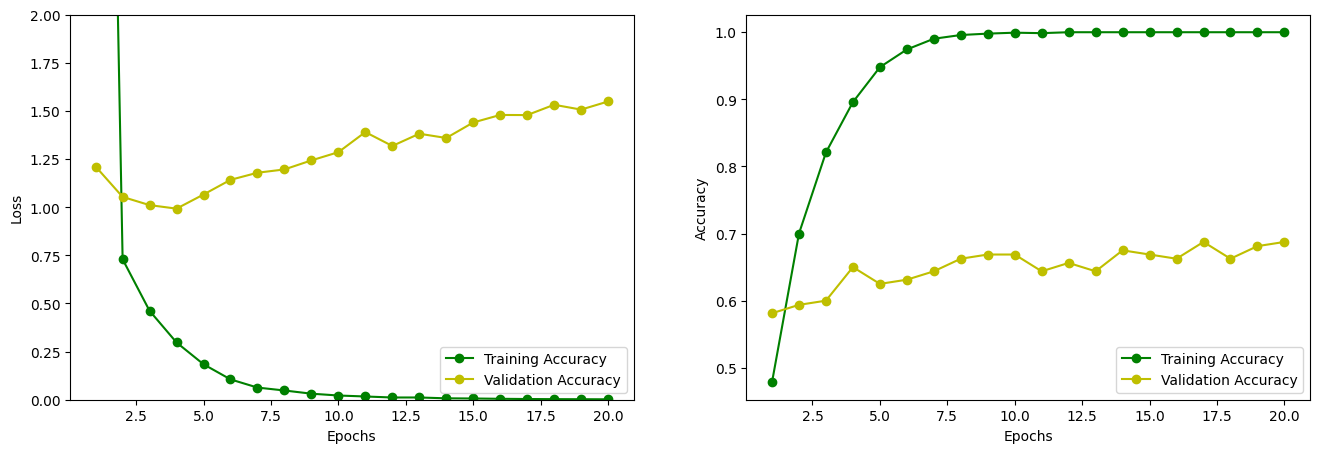

In [20]:
# Courbes de perte et d'accuracy
plt.figure(figsize = (16,5))

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

plt.subplot(121)
plt.plot(epochs, train_loss, 'g-o', label = 'Training Accuracy')
plt.plot(epochs, val_loss, 'y-o',  label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,2)

plt.subplot(122)
plt.plot(epochs, train_acc, 'g-o', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'y-o',  label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show();

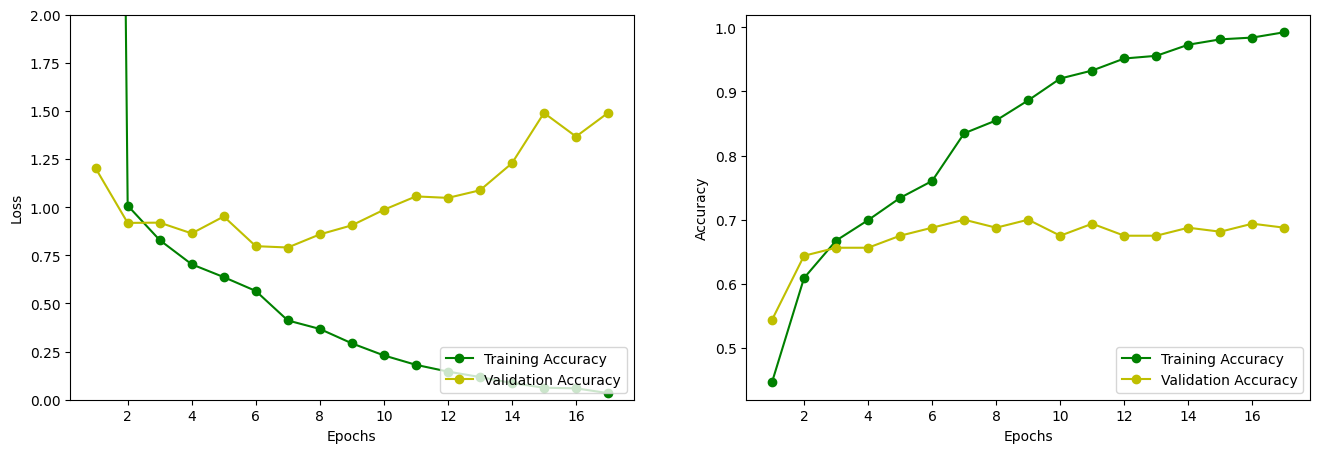

In [21]:
# Courbes de perte et d'accuracy
plt.figure(figsize = (16,5))

train_acc = history_hyper.history['accuracy']
train_loss = history_hyper.history['loss']
val_acc = history_hyper.history['val_accuracy']
val_loss = history_hyper.history['val_loss']

epochs = range(1, len(train_acc) + 1)

plt.subplot(121)
plt.plot(epochs, train_loss, 'g-o', label = 'Training Accuracy')
plt.plot(epochs, val_loss, 'y-o',  label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,2)

plt.subplot(122)
plt.plot(epochs, train_acc, 'g-o', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'y-o',  label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show();

## Model Performance

In [22]:
print('TRAIN accuracy & loss:', hypermodel.evaluate(train_generator))
print('\n')
print('TEST accuracy & loss:', hypermodel.evaluate(test_generator))

45/45 [==============================] - 4s 77ms/step - loss: 0.0253 - accuracy: 0.9931
TRAIN accuracy & loss: [0.02530137449502945, 0.9930555820465088]


13/13 [==============================] - 1s 112ms/step - loss: 1.2679 - accuracy: 0.7225
TEST accuracy & loss: [1.267889142036438, 0.7225000262260437]


In [ ]:
#### Predictions 

In [23]:
y_test = test_generator.classes
y_test = pd.DataFrame(y_test).astype(int)

y_pred = np.argmax(hypermodel.predict(test_generator), axis = 1)

13/13 [==============================] - 2s 120ms/step


In [ ]:
#### Confusion Matrix

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion Matrix',
                          cmap = plt.cm.Blues):
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 fontsize = 12,
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

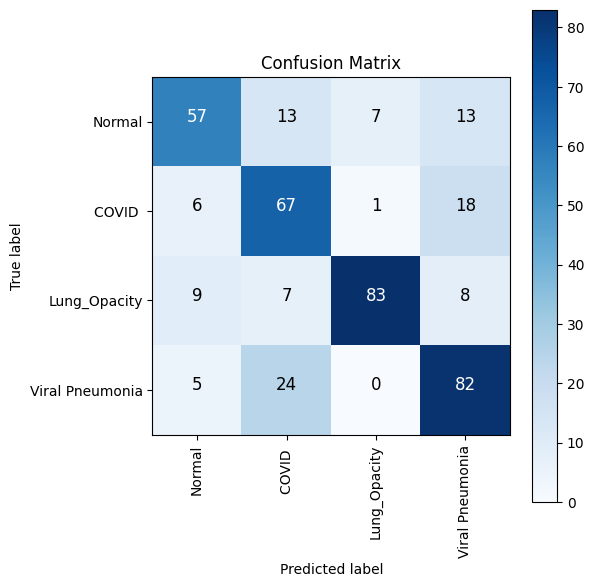

[[57 13  7 13]
 [ 6 67  1 18]
 [ 9  7 83  8]
 [ 5 24  0 82]]


In [25]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm, classes, normalize = False)
print(cm)

In [ ]:
#### Classification Report

In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.63      0.68        90
           1       0.60      0.73      0.66        92
           2       0.91      0.78      0.84       107
           3       0.68      0.74      0.71       111

    accuracy                           0.72       400
   macro avg       0.73      0.72      0.72       400
weighted avg       0.74      0.72      0.73       400



In [ ]:
## Predictions on Test Images 

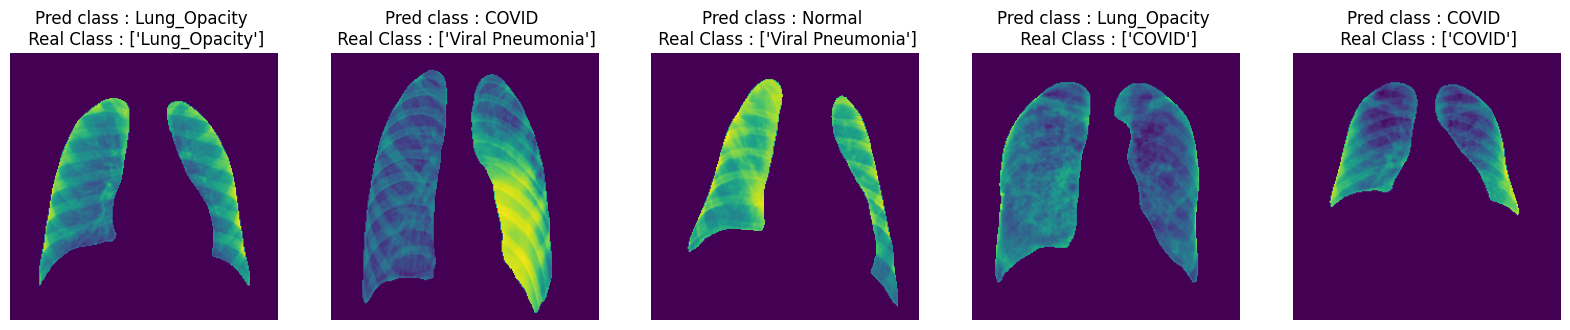

In [27]:
#Prédiction du modèle

indices_random = tf.random.uniform([5], 0, len(test['filepath']), dtype = tf.int32)

plt.figure(figsize = (20,7))

for i, idx in enumerate(indices_random) :
    plt.subplot(1,5,i+1)
    plt.imshow(tf.cast(X_test[idx], tf.int32))
    plt.axis('off')
    plt.title('Pred class : {} \n Real Class : {}'.format(df.nameLabel.unique()[y_pred[idx]], df.nameLabel.unique()[y_test.values[idx]]))

In [28]:
model.save_weights("model_lenet_kerastuner_2000mkd.h5")

In [ ]:
model.load_weights("C:/Users/utilisateur/COVID19 - Projet/model_lenet_kerastuner_2000mkd.h5")